In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
# Assuming df is your DataFrame
pd.set_option('display.max_columns', None)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import pickle

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716701455928, experiment_id='1', last_update_time=1716701455928, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
url1 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet'

In [9]:
url2 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet'

In [10]:
df = pd.read_parquet(url1)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[(df.duration>=1) & (df.duration<=60)]

categorical =['PULocationID','DOLocationID']
numerical =['trip_distance']

df[categorical] = df[categorical].astype(str)

#### Dictionary Vectorizer takes dictionary as input

In [11]:
# COnvert datafromae into dictionary, i.e each row of dataframe is converted into a dictionary.
train_dicts = df[categorical + numerical].to_dict(orient = 'records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


target = 'duration'
Y_train = df[target].values


# Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)


Y_preds = lr.predict(X_train)

mean_squared_error(Y_train, Y_preds)

49.562498271367254

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


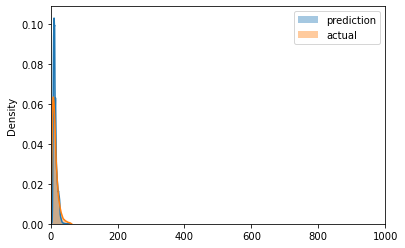

In [12]:
sns.distplot(Y_preds, label= 'prediction')
sns.distplot(Y_train, label = 'actual')

# Set x-axis limit to focus on the concentrated region
plt.xlim(0, 1000)  # Adjust the limits according to your data

plt.legend()

In [13]:
def read_dataframe(url):
    df = pd.read_parquet(url1)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration>=1) & (df.duration<=60)]

    categorical =['PULocationID','DOLocationID']
    numerical =['trip_distance']

    df[categorical] = df[categorical].astype(str)

    return df

In [14]:
df_train = read_dataframe(url1)
df_val = read_dataframe(url2)

In [15]:
len(df_train), len(df_val)

(65946, 65946)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] +'_'+ df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] +'_'+ df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #['PULocationID','DOLocationID']
numerical =['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.fit_transform(val_dicts)

In [18]:
target = 'duration'
Y_train = df_train[target].values
Y_val = df_val[target].values

In [20]:
# Linear Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","linear-regression")
    
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    #mlflow.log_params("alpha",alpha)
    lr = LinearRegression()
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)

    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    print(rmse)

4.754276878808011


In [21]:
# Lasso Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","Lasso-Regression")
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)
    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    rmse

In [22]:
# Ridge Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","Ridge-Regression")
    
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    
    lr = Ridge()
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)
    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    print(rmse)

5.704636733905528


In [ ]:
%pwd

In [ ]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)